In [1]:
from matplotlib import pyplot as plt
from torch import Tensor

from src.common.log import logger
from src.dataset.tno_dataset_collection import TnoDatasetCollection
from src.inverse_problems.compressed_sensing_problem import (
    TotalEmissionsCompressedSensingExperiment,
)
from src.inverse_problems.footprints.footprint_loader import load_gaussian_plume_footprint
from src.inverse_problems.inverse_problems_solver import (
    BasisPursuitSolver,
    GenerativeModelSolver,
    SparsityTransform,
    SparseGenerativeModelSolver,
)
from src.models.common.metrics import relative_error, ssim
from src.plotting.city_emission_field_plot import plot_emission_field_tensor

In [2]:
dataset = TnoDatasetCollection()

[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2015_highres_by_city.csv'
[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2018_highres_by_city.csv'
[INFO] > Test Set has 13 unique cites!                           
	Dresden, Szczecin, Győr, Magdeburg, Aachen, Siegen, Großzschocher, Reims, Hamburg, Innsbruck, Prague, Duisburg, Gdynia
[INFO] > Validation Set has 15 unique cites!
	Bielefeld, Wałbrzych, Frankfurt am Main, Angers, Bydgoszcz, Linz, Zielona Góra, Brussels, Kassel, Koblenz, Southampton, Ingolstadt, Kalisz, Nijmegen, Erfurt
[INFO] > Training Set has 74 unique cites!
	Koszalin, Reading, Saint Peters, Berlin, Apeldoorn, Ulm, Eindhoven, Poznań, Odense, Charleroi, Brighton, Leicester, Breda, Nantes, Pilsen, Southend-on-Sea, Würzburg, Karlsruhe, Metz, Le Mans, Wrocław, Hastings, Köln, Bremen, Amsterdam, Chemnitz, Kiel, Brugge, Rouen, Rostock,

In [3]:
CITY = "Munich"

emission_field = dataset.get_single_case_study_city_emission_field(city=CITY, year=2018)
x_a = emission_field.co2_ff_area_sources_tensor.sum(0)
x_p = emission_field.co2_ff_point_sources_tensor.sum(0)
x = x_a + x_p

In [4]:
sensing_matrix = load_gaussian_plume_footprint(num_stations=50)

snr = 100

problem = TotalEmissionsCompressedSensingExperiment.generate_from_sensing_matrix(
    x,
    Tensor(sensing_matrix),
    snr=snr
)

problem.inverse_problem.y -= problem.inverse_problem.A @ x_p.reshape(32 * 32)

In [5]:
bp_solver = BasisPursuitSolver(verbose=False)
bp_solver_dwt = BasisPursuitSolver(transform=SparsityTransform.DWT, verbose=False)
bp_solver_dct = BasisPursuitSolver(transform=SparsityTransform.DCT, verbose=False)

gen_solver_256 = GenerativeModelSolver.from_vae_model_name("256", plot_loss=True)
gen_solver_512 = GenerativeModelSolver.from_vae_model_name("512", plot_loss=True)
gen_solver_1024 = GenerativeModelSolver.from_vae_model_name("1024", plot_loss=True)
gen_solver_2048 = GenerativeModelSolver.from_vae_model_name("2048", plot_loss=True)

gen_solver_512_munich = GenerativeModelSolver.from_vae_model_name("512_munich", plot_loss=True)
gen_solver_2048_munich = GenerativeModelSolver.from_vae_model_name("2048_munich", plot_loss=True)

sparse_gen_solver_2048 = SparseGenerativeModelSolver.from_vae_model_name("2048", plot_loss=True)

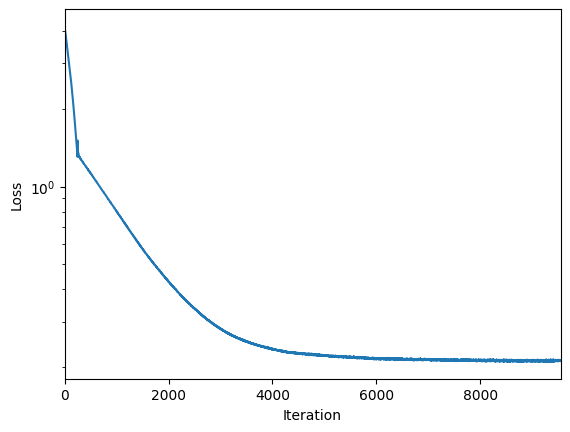

In [6]:
x_rec = problem.solve(sparse_gen_solver_2048, lambda_=0.005, learning_rate=2e-4)

In [7]:
logger.info(f"SSIM={ssim(x_a, x_rec):.3f}")
logger.info(f"Relative Error={100 * relative_error(x_a, x_rec):.3f}%")

[INFO] > SSIM=0.567
[INFO] > Relative Error=46.912%


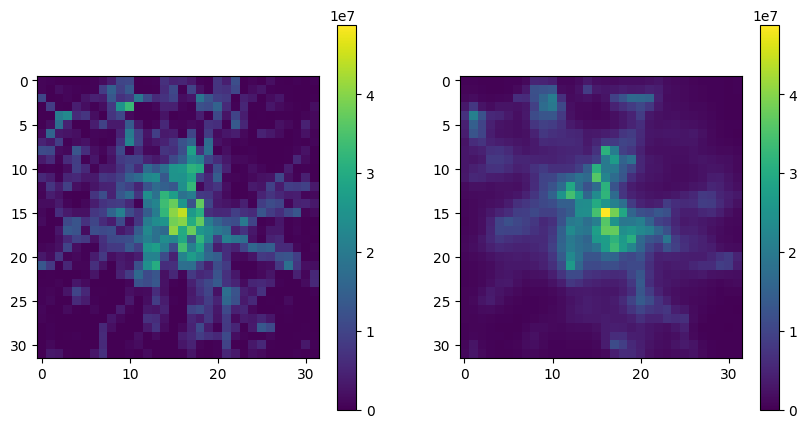

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

vmax = 1.1 * float(x_a.max())

plot_emission_field_tensor(ax=ax1, emission_field=x_a, vmax=vmax)
plot_emission_field_tensor(ax=ax2, emission_field=x_rec, vmax=vmax)